This is a guided example referencing https://github.com/andrewwlong/diabetes_readmission/blob/master/diabetes_project.ipynb  
Confusion Matrix reference https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea

In [157]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, confusion_matrix
import seaborn as sns

### Load Data

In [158]:
data = pd.read_csv('diabetic_data.csv', na_values = '?')
data.info()

C:\Users\ssear\anaconda3\envs\py36\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      99493 non-null   object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    3197 non-null    object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                61510 non-null   object
 11  medical_specialty         51817 non-null   object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

# Data Preparation

### Update Diagnosis ID Codes

In [159]:
def convert_code(code):
    try:
        code = float(code)
        if code >= 1 and code <= 139:
            return 1
        elif code >= 140 and code <= 239:
            return 2
        elif code >= 240 and code <= 279:
            return 3
        elif code >= 280 and code <= 289:
            return 4
        elif code >= 290 and code <= 319:
            return 5
        elif code >= 320 and code <= 389:
            return 6
        elif code >= 390 and code <= 459:
            return 7
        elif code >= 460 and code <= 519:
            return 8
        elif code >= 520 and code <= 579:
            return 9
        elif code >= 580 and code <= 629:
            return 10
        elif code >= 630 and code <= 679:
            return 11
        elif code >= 680 and code <= 709:
            return 12
        elif code >= 710 and code <= 739:
            return 13
        elif code >= 740 and code <= 759:
            return 14
        elif code >= 760 and code <= 779:
            return 15
        elif code >= 780 and code <= 799:
            return 16
        elif code >= 800 and code <= 999:
            return 17
    except:
        if 'V' in code:
            return 18
        elif 'E' in code:
            return 19
        else:
            return 'Code not mapped'

data['diag_1_mapped'] = data.diag_1.apply(convert_code)
data['diag_2_mapped'] = data.diag_2.apply(convert_code)
data['diag_3_mapped'] = data.diag_3.apply(convert_code)

### Remove Discharge IDs relating to Hospice or Death

In [160]:
data = data.loc[~data.discharge_disposition_id.isin([11,13,14,18,20,21])]

### Create Target Variable

In [163]:
data['Target_Label'] = (data.readmitted == '<30').astype(int)

### Numerical Predictors

In [165]:
num_col_names = ['time_in_hospital','num_lab_procedures', 'num_procedures', 'num_medications',\
                 'number_outpatient', 'number_emergency', 'number_inpatient','number_diagnoses']

### Categorical Predictors

In [166]:
cat_col_names = ['race', 'gender', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide',\
                 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',\
                 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',\
                 'miglitol', 'troglitazone','tolazamide', 'insulin', 'glyburide-metformin',\
                 'glipizide-metformin','glimepiride-pioglitazone', 'metformin-rosiglitazone',\
                 'metformin-pioglitazone', 'change', 'diabetesMed','payer_code']

# Fill NA with 'UNK'
data['race'] = data['race'].fillna('UNK')
data['payer_code'] = data['payer_code'].fillna('UNK')
data['medical_specialty'] = data['medical_specialty'].fillna('UNK')
data['diag_1_mapped'] = data['diag_1_mapped'].fillna('UNK')
data['diag_2_mapped'] = data['diag_2_mapped'].fillna('UNK')
data['diag_3_mapped'] = data['diag_3_mapped'].fillna('UNK')


In [172]:
# Get top 10 medical specialties
top_10_spec = data['medical_specialty'].value_counts(dropna=False)[0:10].index.tolist()

# New medical_specialty column
data['med_spec_new'] = data['medical_specialty'].copy()

In [174]:
# Replace values with 'Other' if not in Top 10
data.loc[~data.med_spec_new.isin(top_10_spec), 'med_spec_new'] = 'Other'

In [176]:
# Convert Numerical Categorical Columns to strings
cat_col_num = ['admission_type_id', 'discharge_disposition_id', 'admission_source_id',\
               'diag_1_mapped', 'diag_2_mapped', 'diag_3_mapped']
data[cat_col_num] = data[cat_col_num].astype(str)

### Features

In [178]:
# Create Age Group Variable
age_dict = {'[0-10)':0, 
            '[10-20)':10, 
            '[20-30)':20, 
            '[30-40)':30, 
            '[40-50)':40, 
            '[50-60)':50,
            '[60-70)':60, 
            '[70-80)':70, 
            '[80-90)':80, 
            '[90-100)':90}
data['age_group'] = data.age.replace(age_dict)

# Create Age Variable
data['has_weight'] = data.weight.notnull().astype('int')

# Save feature names
features = ['age_group', 'has_weight']

### Summary of Variables for Modeling

In [153]:
print('Total number of predictors:', len(num_col_names + cat_col_names + cat_col_num + ['med_spec_new'] + features))
print('Numerical predictors:',len(num_col_names))
print('Categorical predictors:',len(data_cat_cols))
print('Features:',len(features))

Total number of predictors: 45
Numerical predictors: 8
Categorical predictors: 35
Features: 2


In [199]:
model_data = data[num_col_names + cat_col_names + cat_col_num + ['med_spec_new'] + features + ['Target_Label']]

# Modeling Prep

### Split Data

In [201]:
# Shuffle Data
model_data = model_data.sample(n=len(model_data),random_state=10)
model_data = model_data.reset_index(drop=True)

# 20% Validation / 80% Train
vd_data = model_data.sample(frac=0.2, random_state=10)
train_data = model_data.drop(vd_data.index)

In [202]:
print('Readmission Rates by Set')
print('Validation: ', vd_data[vd_data['Target_Label']==1].shape[0]/vd_data.shape[0])
print('Train: ', train_data[train_data['Target_Label']==1].shape[0]/train_data.shape[0])

Readmission Rates by Set
Validation:  0.11749947731549237
Train:  0.11246863892954213


### Balance Training Data

In [203]:
# Split training data into positive and negative
positive = train_data.Target_Label == 1
train_data_pos = train_data.loc[positive]
train_data_neg = train_data.loc[~positive]

# Merge and Balance
train_data_balanced = pd.concat([train_data_pos, train_data_neg.sample(n = len(train_data_pos), random_state=10)], axis = 0)

# Shuffle
train_data_balanced = train_data_balanced.sample(n = len(train_data_balanced), random_state = 10).reset_index(drop=True)

print('Readmission Rates by Set')
print('Validation: ', vd_data[vd_data['Target_Label']==1].shape[0]/vd_data.shape[0])
print('Train: ', train_data[train_data['Target_Label']==1].shape[0]/train_data.shape[0])
print('Train Balanced: ', train_data_balanced[train_data_balanced['Target_Label']==1].shape[0]/train_data_balanced.shape[0])

Readmission Rates by Set
Validation:  0.11749947731549237
Train:  0.11246863892954213
Train Balanced:  0.5


In [205]:
train_data_balanced.to_csv('diabetes_train.csv', index=False)
vd_data.to_csv('diabetes_vd.csv', index=False)

# Modeling Report Function

In [20]:
def report(actual, predicted):
    AUC = roc_auc_score(actual, predicted)
    accuracy = accuracy_score(actual, predicted)
    precision = precision_score(actual, predicted)
    recall = recall_score(actual, predicted)
    print('AUC: ', AUC)
    print('Accuracy: ', accuracy)
    print('Precision: ', precision)
    print('Recall: ', recall)
    print('Confusion Matrix:')
    conf_matrix = confusion_matrix(actual, predicted)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in conf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in conf_matrix.flatten()/np.sum(conf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(conf_matrix, annot=labels, fmt='', cmap='Blues')
    
    cost = ((int(group_counts[1])*1780)+(int(group_counts[2])*14400))/len(actual)
    print('Cost: ',cost)
    
    return AUC, accuracy, precision, recall, cost

# Random Forest with H2O

In [22]:
import h2o
from h2o.estimators import H2ORandomForestEstimator
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; OpenJDK 64-Bit Server VM (build 11.0.6+8-b765.1, mixed mode)
  Starting server from C:\Users\ssear\anaconda3\envs\py36\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\ssear\AppData\Local\Temp\tmpme2chzqh
  JVM stdout: C:\Users\ssear\AppData\Local\Temp\tmpme2chzqh\h2o_ssear_started_from_python.out
  JVM stderr: C:\Users\ssear\AppData\Local\Temp\tmpme2chzqh\h2o_ssear_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,America/Chicago
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.4
H2O_cluster_version_age:,4 months and 25 days !!!
H2O_cluster_name:,H2O_from_python_ssear_uj90rq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,5.973 Gb
H2O_cluster_total_cores:,0
H2O_cluster_allowed_cores:,0
H2O_cluster_status:,"accepting new members, healthy"


In [206]:
# Load data as frame
train_data = h2o.import_file('diabetes_train.csv')
validation_data = h2o.import_file('diabetes_vd.csv')

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [220]:
# Set predictor and response columns
training_columns = num_col_names + cat_col_names + cat_col_num + ['med_spec_new'] + features
response_column = 'Target_Label'

In [222]:
# Set Model
drf = H2ORandomForestEstimator(ntrees=50, max_depth=20, nfolds=10)

In [267]:
# Fit Model
drf.train(x=training_columns, y=response_column, training_frame=train_data)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [269]:
# Get Predictions
predictions = drf.predict(validation_data)

drf prediction progress: |████████████████████████████████████████████████| 100%


C:\Users\ssear\anaconda3\envs\py36\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'chlorpropamide' has levels not trained on: [Down, Up]
  warnings.warn(w)
C:\Users\ssear\anaconda3\envs\py36\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'payer_code' has levels not trained on: [FR]
  warnings.warn(w)


In [277]:
# Get predictions and vd back into a pandas df
predictions_as_df = h2o.as_list(predictions)
vd_as_df = h2o.as_list(validation_data)
vd_as_df['prediction'] = predictions_as_df
vd_as_df['prediction'] = vd_as_df['prediction'].round(0)
vd_as_df['prediction'] = vd_as_df['prediction'].astype(int)
vd_as_df

Validation:
AUC:  0.6158193421133613
Accuracy:  0.6251306711269078
Precision:  0.17766431002880334
Recall:  0.6036476868327402
Confusion Matrix:
Cost:  1254.9958185239389


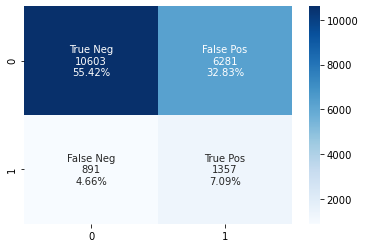

In [284]:
print('Validation:')
rf_vd_AUC, rf_vd_accuracy, rf_vd_precision, rf_vd_recall, rf_vd_cost = report(vd_as_df.Target_Label, vd_as_df.prediction)